**Test Script For FRA333 HW3**
- Member
    - นายปวริศ อัศวกิจธนานนท์ 653405000347

In [2]:
import roboticstoolbox as rtb
import numpy as np
from math import pi
from spatialmath import *
from HW3_utils import *
from FRA333_HW3_6537 import *

### **Robot Modeling**
- define DH parameter of Robot

In [3]:
d1 = 0.0892
a2 = -0.425
T_3_e = SE3(-0.39243,-0.093,0.109) * SE3(-0.082,0,0) * SE3.RPY([0,-pi/2,0])
robot = rtb.DHRobot(
    [
        rtb.RevoluteMDH(d = d1 , offset=pi), # {1}
        rtb.RevoluteMDH(alpha=pi/2), # {2}
        rtb.RevoluteMDH(a=a2), # {3}
    ],tool = T_3_e, name="6R robot")
print(robot)

DHRobot: 6R robot, 3 joints (RRR), dynamics, modified DH parameters
┌────────┬───────┬────────────┬────────┐
│  aⱼ₋₁  │ ⍺ⱼ₋₁  │     θⱼ     │   dⱼ   │
├────────┼───────┼────────────┼────────┤
│    0.0 │  0.0° │  q1 + 180° │ 0.0892 │
│    0.0 │ 90.0° │         q2 │    0.0 │
│ -0.425 │  0.0° │         q3 │    0.0 │
└────────┴───────┴────────────┴────────┘

┌──────┬─────────────────────────────────────────────────┐
│ tool │ t = -0.47, -0.093, 0.11; rpy/xyz = 0°, -90°, 0° │
└──────┴─────────────────────────────────────────────────┘



- Home Position 

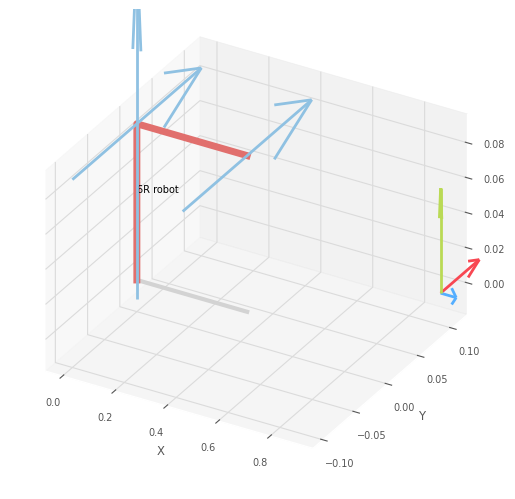

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, '6R robot')

<Figure size 640x480 with 0 Axes>

In [4]:
q = [0,0,0]
robot.plot(q)

### **Validation**

**Forward Kinematic test**

In [13]:
print("Pose from RTB-py")
print(robot.fkine(q))
print("___________________________________________\n\n")
print("Pose from HW3")
R,P,R_e,p_e = FKHW3(q)
print(f"Position is {p_e}")
print("Orinetation Matrix")
print(R_e)

Pose from RTB-py
  -0.09983  -0.8151    0.5707    0.1222    
   0.995    -0.08178   0.05726   0.1218    
   0         0.5735    0.8192    0.7914    
   0         0         0         1         

___________________________________________


Pose from HW3
Position is [0.12217042 0.12180521 0.79137568]
Orinetation Matrix
[[-9.9833414e-02 -8.1509900e-01  5.7065475e-01]
 [ 9.9500418e-01 -8.1782691e-02  5.7256460e-02]
 [ 4.6189296e-17  5.7352000e-01  8.1919158e-01]]


**1. Jacobian Test**
- Jacobian matrix at end-effector frame relate to base frame (frame 0)

this function is random joint angles between (-pi , pi)

In [20]:
def JacobianTest(robot):
    q1,q2,q3 = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)
    q = [q1,q2,q3]
    print("Jacobian from RTB-py")
    print(robot.jacob0(q))
    print("___________________________________________\n")
    print("Jacobian from HW3")
    print(endEffectorJacobianHW3(q))

In [35]:
JacobianTest(robot)     # Random Joint Angle and compare result of Jacobian matrix 

Jacobian from RTB-py
[[ 3.86180993e-01 -2.61914386e-01 -1.14762756e-01]
 [-2.63347207e-01 -6.89274426e-01 -3.02018662e-01]
 [ 1.59374860e-17  4.54539889e-01  3.59648526e-01]
 [-4.62899783e-17 -9.34788037e-01 -9.34788037e-01]
 [-1.06226380e-16  3.55206033e-01  3.55206033e-01]
 [ 1.00000000e+00  6.12323400e-17  6.12323400e-17]]
___________________________________________

Jacobian from HW3
[[ 3.86180993e-01 -2.61914393e-01 -1.14762759e-01]
 [-2.63347207e-01 -6.89274435e-01 -3.02018666e-01]
 [ 0.00000000e+00  4.54539896e-01  3.59648532e-01]
 [ 0.00000000e+00 -9.34788048e-01 -9.34788048e-01]
 [ 0.00000000e+00  3.55206043e-01  3.55206043e-01]
 [ 1.00000000e+00  6.12323426e-17  6.12323426e-17]]


**2. Singularity test**
- for RRR Robot Singularity


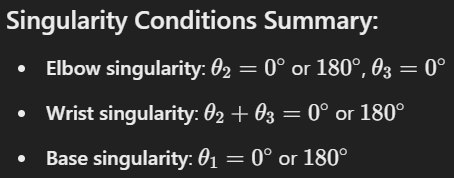

In [115]:
def SingularityFinding():
    for i in range(1000):
        try:
            q1,q2,q3 = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)
            q = [q1,q2,q3]
            robot.jacob0(q)
            J_full = endEffectorJacobianHW3(q)  # Full Jacobian
            J_reduce = J_full[0:3, 0:3]         # Reduced Jacobian for 3-DoF
            rank = np.linalg.matrix_rank(J_reduce)
        except:
            return q

In [158]:

q = [2,pi/4,pi/4]
robot.jacob0(q)
J_full = endEffectorJacobianHW3(q)  # Full Jacobian
J_reduce = J_full[0:3, 0:3]         # Reduced Jacobian for 3-DoF
rank = np.linalg.matrix_rank(J_reduce)
print(rank)
print(np.linalg.det(J_reduce))

3
0.03538726292795425


**3. Joint Effort test**

In [37]:
q = [0.1,-2.1,1.14]
w = [5,2,8,4,5,10]
m_e = w[:3] # moment
f_e = w[3:] # force
w_e = np.concatenate((f_e, m_e),axis = 0)   # Concatenate to Wrench vector
a = robot.pay(W= w_e , q = q,frame=1)       # Calculating Joint Effort from RTB-py
b = computeEffortHW3(q,w)                   # Calculating Joint Effort from HW3
print(f"Joint Effort RTB : {a}")
print(f"Joint Effort HW3 : {b}")

Joint Effort RTB : [-8.05677637 -4.67215404 -1.69785   ]
Joint Effort HW3 : [8.05677649 4.67215407 1.69785001]


Joint Effort RTB 
- Refers to the torque required by the manipulator to counteract the external force applied at the end-effector.

Joint Effort HW3 
- Refers to the torque generated by the external force acting on the manipulator.

random test case for Joint Effort test

In [38]:
def JointEffortTest(robot):
    q1,q2,q3 = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)
    q = [q1,q2,q3]
    w = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)

    m_e = w[:3] # moment
    f_e = w[3:] # force
    w_e = np.concatenate((f_e, m_e),axis = 0)   # Concatenate to Wrench vector
    a = robot.pay(W= w_e , q = q,frame=1)       # Calculating Joint Effort from RTB-py
    b = computeEffortHW3(q,w)                   # Calculating Joint Effort from HW3
    print(f"Joint Effort RTB : {a}")
    print(f"Joint Effort HW3 : {b}")

In [84]:
JointEffortTest(robot)

Joint Effort RTB : [1.75370616 1.76404669 2.21294333]
Joint Effort HW3 : 0
